<a href="https://colab.research.google.com/github/alvumu/TGINE/blob/main/Practica1/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scrapy rawling JSON-LD (DigitalTrends)

## Parte 1- Compilar datos de documentos web (0,75 puntos)
En el ejemplo siguiente definimos un crawler en Scrapy para extraer noticias de los metadatos de las páginas web.
DigitalTrends y otros blogs publican metadatos en formato JSON-LD (https://json-ld.org/) que permite obtener información estructurada de las webs. En este caso, tendremos que obtener esos objetos JSON-LD y extraer su información en el formato de noticia (https://schema.org/NewsArticle) publicado en Schema.org


In [ ]:
!pip3 install -U scrapy

In [35]:
!pip3 install stanza
import stanza
stanza.download('en')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 10.9 MB/s eta 0:00:00


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [ ]:
import scrapy
import sys
import json
import locale
import time
import random

import hashlib

from bs4 import BeautifulSoup


# Para cada crawler que nos definimos nos debemos crear una clase Spider que debe heredar de la clase scrapy.Spider

class DigitalTrendsSpider (scrapy.Spider):
    name = 'DigitalTrends'

    # Decimos que el dominio válido es el de la UM
    allowed_domains = ['www.digitaltrends.com']

    # podemos definir las páginas de inicio
    start_urls = ['https://www.digitaltrends.com']

    # para evitar que el sitio te bloquee por usar scrapy es interesante cambiar el USER_AGENT
    # El user agent por defecto de Scrapy cuando hace una petición es
    # Scrapy/VERSION (+https://scrapy.org)
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    }

    nDocumentos = 0
    visited_urls = set()

    # debemos de implementar este método que se llamará para cada una de las páginas que se vayan analizando
    def parse (self, response):
        """
        @inherit

        @param self
        @param response
        """

        if self.nDocumentos >= 1500:
          return

        # Guardamos la URL del sitio que se está visitando
        url = str(response.request.url).strip()

        # Cogemos el contenido relevante y para eso debemos usar selectores CSS
        for article in response.css ('.b-page '):

            # Cogemos el contenido del título
            title = str (article.css ('.b-headline__title  ').get ()).strip()
            title = BeautifulSoup (title, 'html.parser').get_text().strip()

            # autor
            autor = str (article.css ('.author.url.fn ').get ()).strip()
            autor = BeautifulSoup (autor, 'html.parser').get_text().strip()

            # Date
            date = str (article.css ('.b-byline__time.date.dtreviewed').get ()).strip()
            date = BeautifulSoup (date, 'html.parser').get_text().strip()

            #Content
            content = "".join (article.css ('.b-content.b-single__content.h-article-content ').get ())
            content = BeautifulSoup (content, 'html.parser').get_text().strip().replace("\"","").replace("\n","")

            data = {
                'url' : url,
                'title': title,
                'autor': autor,
                'date': date,
                'content': content
            }


            title_hash = hashlib.md5(title.encode()).hexdigest()

            filename = f"{title_hash}.json"

            # Guardamos el documento si tiene contenido y título
            if content and title:
                print ("-------------------------")
                print (url)
                print (title)
                print (autor)
                print (date)
                print (content)
                print ("-------------------------")
                self.nDocumentos = self.nDocumentos + 1
                with open ('digitalTrends/' + filename, 'w') as f:
                    json.dump (data, f, indent = 4)



        # Obtenemos todas las otros links de la página representados por la etiqueta <a>


        url_in_current_document = response.css ('a')

        for next_page in url_in_current_document:
            # Para limitar que solamente se parseen las noticias dentro de 'https://www.digitaltrends.com/computing/ o https://www.digitaltrends.com/mobile/'
            # obtenemos el atributo href de la etiqueta <a> y parseamos la página

            url_str = str(next_page.css('::attr(href)').get())


            if ("https://www.digitaltrends.com/computing/" in url_str) or ("/mobile/" in url_str) and url_str not in self.visited_urls and self.nDocumentos < 1500:
              self.visited_urls.add(url_str)
              yield response.follow (next_page, self.parse)

In [ ]:
import os
import scrapy
from scrapy.crawler import CrawlerProcess

# Creamos un proceso de Crawler podemos poner distintas settings que están definidas en la documentación.
# Entre ellas podemos ocular los logs del proceso de Crawling.
process = CrawlerProcess(settings={
    "LOG_ENABLED": False,
    # Used for pipeline 1
})

# Como se ha definido anteriormente en el RSSCrawler, los ficheros se van a almacenar en la carpeta "rss"
# Comprobamos que existe la carpeta y si no existe la creamos
if (not os.path.exists('digitalTrends')):
    os.mkdir('digitalTrends')

# Creamos el proceso con el RSSSpider
process.crawl(DigitalTrendsSpider)
# Ejecutamos el Crawler
process.start()

DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/chatgpt-can-browse-the-internet-again/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/openai-fires-ceo/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/chatgpt-bing-hands-on/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/heres-why-people-are-saying-gpt-4-is-getting-lazy/> (referer: https://www.digitaltrends.com/computing/how-to-use-openai-chatgpt-text-generation-chatbot/)
DEBUG:scrapy.core.engine:Crawled (200) <GET https://www.digitaltrends.com/computing/ia-writer-7-chatgpt-dialog-partner/> 

In [ ]:
def contar_archivos_en_carpeta(ruta):
    try:
        # Lista todos los archivos en la carpeta
        archivos = os.listdir(ruta)

        # Filtra solo los archivos (no directorios)
        archivos = [archivo for archivo in archivos if os.path.isfile(os.path.join(ruta, archivo))]

        # Devuelve el número de archivos
        return len(archivos)
    except Exception as e:
        print(f"Error al contar archivos: {e}")
        return None

contar_archivos_en_carpeta("digitalTrends")

1500

# Parte 2 – Buscador (0,75 puntos)


In [26]:
!pip install whoosh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 7.1 MB/s eta 0:00:00


In [27]:
from whoosh.index import create_in, open_dir
from whoosh.fields import Schema, TEXT, ID, DATETIME
from whoosh.qparser import QueryParser
from datetime import datetime
from dateutil import parser
from whoosh.analysis import StemmingAnalyzer
import re


In [28]:
# Define el esquema para el índice de Whoosh
schema = Schema(
    url=ID(unique=True, analyzer = StemmingAnalyzer()),
    title=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    author=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    date=DATETIME(stored=True),
    content=TEXT(stored=True,analyzer = StemmingAnalyzer())
)

#Define el directorio donde se guardará el esquema, si no existe se crea
index_dir = "whooshIndex"
if not os.path.exists(index_dir):
    os.mkdir(index_dir)
    ix = create_in(index_dir, schema)
else:
    ix = open_dir(index_dir)



In [29]:
# Utiliza el bloque 'with' para garantizar que el índice se cierre correctamente
with ix.writer() as writer:
# Recorre todos los archivos en el directorio digitalTrends
  for filename in os.listdir('digitalTrends'):
      if filename.endswith(".json"):  # Nos aseguramos de que sean archivos JSON
          file_path = os.path.join('digitalTrends', filename)
          with open(file_path, 'r', encoding='utf-8') as file:
              try:
                  file_data = json.load(file) # Cargamos el fichero json
                  date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date']) #Mediante una expresion regular parseamos el campo de la fecha
                  if date_string_clean != "None" :  # En caso de que haga match la expresión regular
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y') # Convertimos en objeto date
                  else :
                    date_obj = None
                  # Se agrega los documentos al índice
                  writer.add_document(
                     url=file_data['url'],
                     title=file_data['title'],
                     author=file_data['autor'],
                     date = date_obj,
                     content=file_data['content']
                  )
              except json.JSONDecodeError as e:
                  print(f"Error al procesar el archivo {filename}: {e}")



In [30]:
from whoosh.index import open_dir
from whoosh.qparser import QueryParser,FuzzyTermPlugin
from whoosh import scoring
from whoosh.spelling import QueryCorrector
from whoosh.highlight import Highlighter, ContextFragmenter
from whoosh.qparser.dateparse import DateParserPlugin
from whoosh.analysis import StemmingAnalyzer


# Función para realizar búsquedas
def buscar_en_archivos(queryWords="", queryDate="", sortedBy="date", directory='whooshIndex'):
    # Se abre el índice existente o se crea uno nuevo si no existe
    ix = open_dir(directory)

    # Se crea un QueryParser para buscar en los campos específicos
    with ix.searcher(weighting=scoring.BM25F()) as searcher:
        #Indicamos que el parser va a ser sobre el campo content
        parser = QueryParser("content", schema=ix.schema)
        #Añadimos los plugins necesarios para las funcionalidades descritas
        #Plugin valido para realizar las busquedas por fechas
        parser.add_plugin(DateParserPlugin())
        # Añadir Stemming al parser para búsqueda más flexible
        parser.add_plugin(FuzzyTermPlugin())
        # Se inicializa la consulta combinada con la búsqueda por palabras y fecha
        user_query = parser.parse(queryWords)  # Búsqueda por palabras
        if queryDate:  # Si se proporciona una fecha, se agrega a la consulta
            date_query = parser.parse(queryDate)
            user_query = user_query & date_query

       # Se corrige la consulta en caso de que esté mal realizada
        correction = searcher.correct_query(q=user_query,qstring=queryWords)
        if correction.query != user_query:
          print("Did you mean:", correction.string)
        # Se procede a realizar la busqueda
        search_results = searcher.search(correction.query, limit=None, sortedby=sortedBy)
        # Configuramos el fragmenter para resaltar fragmentos de texto
        fragmenter = ContextFragmenter(maxchars=200, surround=30)
        highlighter = Highlighter(fragmenter=fragmenter)
        # Mostramos los resultados de las noticias que se han encontrado según las condiciones del usuario
        for hit in search_results:
            print(f"Título: {hit['title']}")
            print(f"Autor: {hit['author']}")
            print(f"Fecha: {hit['date']}")
            print(f"Fragmento de contenido: {hit.highlights('content')}")
            print("--------------")


In [31]:
# Llamar a la función para realizar las búsquedas
buscar_en_archivos(queryWords="game", queryDate="date:[2022-01-01 TO 2022-12-28]", sortedBy="author")


Título: Sony’s new InZone gaming headsets raise the bar for PS5 audio
Autor: Arif Bacchus
Fecha: 2022-06-28 00:00:00
Fragmento de contenido: Along with new <b class="match term0">gaming</b> monitors, Sony has...PC and PlayStation <b class="match term1">games</b>. The range includes...pressure so you can <b class="match term2">game</b> for hours. You can expect
--------------
Título: How to use Handoff on a Mac
Autor: Arif Bacchus
Fecha: 2022-02-01 00:00:00
Fragmento de contenido: a chance to fix Mac <b class="match term0">gaming</b> for good in 2024									Save
--------------
Título: How to use Handoff on a Mac
Autor: Arif Bacchus
Fecha: 2022-02-01 00:00:00
Fragmento de contenido: a chance to fix Mac <b class="match term0">gaming</b> for good in 2024									Save
--------------
Título: Sony’s new InZone gaming headsets raise the bar for PS5 audio
Autor: Arif Bacchus
Fecha: 2022-06-28 00:00:00
Fragmento de contenido: launched new InZone <b class="match term0">gaming</b> headsets, desig

# Parte 3 – Vectorización (0,5 puntos)

In [ ]:
!pip3 install stanza
import stanza
stanza.download('en')

In [25]:
!unzip digitalTrends.zip -d digitalTrends
!unzip digitalTrendsEntities.zip -d digitalTrendsEntities
!unzip whooshIndex.zip -d whooshIndex
!unzip whooshIndexEntities.zip -d whooshIndexEntities

Archive:  whooshIndex.zip
   creating: whooshIndex/content/whooshIndex/
  inflating: whooshIndex/content/whooshIndex/_MAIN_1.toc  
  inflating: whooshIndex/content/whooshIndex/MAIN_lcnk3i79d12v73cj.seg  
 extracting: whooshIndex/content/whooshIndex/MAIN_WRITELOCK  


In [32]:
import os
import json

# Ruta al directorio 'digitalTrends'
directory_path = 'digitalTrends'

# Lista para almacenar el contenido de 'content' de cada archivo
content_list = []

# Recorre todos los archivos en el directorio 'digitalTrends'
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):  # Se verifica si es un archivo JSON
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                file_data = json.load(file)
                # Se obtiene el campo 'content' de cada archivo y se añade a la lista
                content = file_data.get('content', '')  # Si 'content' no existe, asigna una cadena vacía
                #Añadimos el contenido a la lista
                content_list.append(content)
            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")




In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


import numpy as np

# Crear un objeto TfidfVectorizer con opciones de preprocesamiento
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Usar stopwords del inglés
    min_df=10  # Filtrar términos que aparecen en menos de 10 documentos
)


# Obtener la matriz documento-término
matriz_tfidf = tfidf_vectorizer.fit_transform(content_list)

# Obtener el nombre de las características (términos)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calcular la suma de puntuaciones TF-IDF por término
sum_scores = matriz_tfidf.sum(axis=0)

# Obtener los índices de los términos ordenados por la suma de puntuaciones TF-IDF
top_indices = sum_scores.argsort()[0, ::-1][:10].tolist()

# Obtener solo los términos más relevantes
top_10_terminos = feature_names[top_indices[0][:10]].tolist()


# Mostrar resultados
print("Los 10 términos más relevantes de toda la colección (con mayor TF-IDF):")
print(top_10_terminos)



# Calculamos la matriz de TF usando la función fit_transform
count_vect = CountVectorizer(stop_words='english',min_df=10)
counts = count_vect.fit_transform(content_list)

feature_names_count = count_vect.get_feature_names_out()

# Suma las frecuencias de cada palabra a lo largo de todos los documentos
word_frequencies = np.asarray(counts.sum(axis=0)).reshape(-1)

# Crea un diccionario que mapea cada palabra a su frecuencia
word_freq_dict = dict(zip(feature_names_count, word_frequencies))

# Obtiene las 100 palabras con más apariciones
top_100_words = {key for key, value in sorted(word_freq_dict.items(), key=lambda item:item[1], reverse=True)[:100]}

print("\nLos 100 términos más repetidos en la colección:")
print(top_100_words)


Los 10 términos más relevantes de toda la colección (con mayor TF-IDF):
['apple', 'iphone', 'pro', 'google', 'rtx', 'phone', 'new', 'pixel', 'gaming', 'android']

Los 100 términos más repetidos en la colección:
{'isn', 'recommended', 'time', 'using', 'pc', '10', 'used', 'use', 'battery', 'available', 'google', 'device', 'amd', 'display', 'digital', 'right', 'mobile', 'intel', 've', 'rtx', 'inch', 'fold', 'way', 'xps', 'best', 'laptop', 'better', 'pro', 'price', 'buy', 'screen', 'just', 'high', 'doesn', 'core', '2023', 'support', 'like', 'performance', 'related', 'great', 'good', 'ipad', 'apple', 'case', 'design', 'keyboard', 'year', 'power', 'oneplus', 'copyright', 'need', 'features', '14', '15', 'app', 'work', 'samsung', 'laptops', 'want', 'll', 'nvidia', 'don', 'microsoft', 'permission', 'gpu', 'usb', 'graphics', 'videos', 'does', 'series', 'feature', 'games', 'camera', 'watch', 'windows', 'settings', '11', '13', 'look', 'new', 'comes', 'recommendations', 'pixel', 'apps', 'surface', 

# PARTE 4: Detección de entidades

In [36]:
#Contador de numero de documentos
nDocumentos = 0

# En caso de que se supere el número de documentos maximo ( 10 ) se termina el bucle
for filename in os.listdir('digitalTrends'):
    if nDocumentos >= 10:
        break

    if filename.endswith(".json"):  # Nos aseguramos de que sean archivos JSON
        file_path = os.path.join('digitalTrends', filename)
        with open(file_path, 'r', encoding='utf-8') as file: # Abrimos los ficheros
            try:
                file_data = json.load(file) # Cargamos el fichero JSON
                date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date']) # Parseamos mediante expresión regular el campo de la fecha
                if date_string_clean != "None":
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y') # En caso de encontrar un match con la expresion regular lo convertimos en tipo fecha
                else:
                    date_obj = None

                # Agrega los documentos al índice
                #Creamos un diccionario con las entidades como key
                dictEntities = {t: [] for t in ["LOC", "MISC", "FAC", "ORG", "NORP", "GPE", "PERSON", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL", "DATE"]}
                #Aplicamos stanza los distintos procesadores para obtener las entidades correspondientes
                pipelineStanza = stanza.Pipeline(lang='en', processors='tokenize, mwt, pos, lemma, depparse, ner')
                #Obtenemos el texto que contiene las entidades
                entityTypes = pipelineStanza(file_data['content'])
                # Para cada frase recorremos cada palabra y asignamos la palabra a cada tipo de entidad
                for sentence in entityTypes.sentences:
                    for ent in sentence.ents:
                        if ent.text not in dictEntities[ent.type]:
                            dictEntities[ent.type].append(ent.text)
                # Almacenamos todos los datos en el formato json
                data = {
                    'url': file_data['url'],
                    'title': file_data['title'],
                    'autor': file_data['autor'],
                    'date': file_data['date'],
                    'content': file_data['content'],
                    'location': dictEntities["LOC"],
                    'miscelaneous': dictEntities['MISC'],
                    'norp': dictEntities['NORP'],
                    'facility': dictEntities['FAC'],
                    'organization': dictEntities['ORG'],
                    'countries': dictEntities['GPE'],
                    'person': dictEntities['PERSON'],
                    'product': dictEntities['PRODUCT'],
                    'event': dictEntities['EVENT'],
                    'workOfArt': dictEntities['WORK_OF_ART'],
                    'law': dictEntities['LAW'],
                    'language': dictEntities['LANGUAGE'],
                    'time': dictEntities['TIME'],
                    'percent': dictEntities['PERCENT'],
                    'money': dictEntities['MONEY'],
                    'quantity': dictEntities['QUANTITY'],
                    'ordinal': dictEntities['ORDINAL'],
                    'cardinal': dictEntities['CARDINAL'],
                    'entityDate': dictEntities['DATE']
                }
                # Aplicamos un titulo hash a los archivos
                title_hash = hashlib.md5(file_data['title'].encode()).hexdigest()
                filename = f"Entity{title_hash}.json"

                # Guardamos el documento si tiene contenido y título
                if file_data['content'] and file_data['title']:
                    print("-------------------------")
                    print(file_data['url'])
                    print(file_data['title'])
                    print(file_data['autor'])
                    print(file_data['date'])
                    print(file_data['content'])
                    for k, v in dictEntities.items():
                        print(k + "->" + str(v))
                    print("-------------------------")
                    nDocumentos = nDocumentos + 1
                    if not os.path.exists("digitalTrendsEntities/"):
                        os.mkdir("digitalTrendsEntities/")

                    with open('digitalTrendsEntities/' + filename, 'w') as f:
                        json.dump(data, f, indent=4)

            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")



INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | combined_nocharlm         |
| depparse  | combined_charlm           |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


KeyboardInterrupt: ignored

In [37]:
# Se define el esquema para el nuevo índice de Whoosh
from whoosh.fields import KEYWORD
schema = Schema(
    url=ID(unique=True, analyzer = StemmingAnalyzer()),
    title=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    author=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    date=DATETIME(stored=True),
    content=TEXT(stored=True,analyzer = StemmingAnalyzer()),
    miscelaneous=KEYWORD(stored=True, commas=True),
    location = KEYWORD(stored=True, commas = True),
    norp = KEYWORD(stored=True,commas = True),
    facility = KEYWORD(stored=True,commas = True),
    organization = KEYWORD(stored=True,commas = True),
    countries = KEYWORD(stored=True,commas = True),
    person = KEYWORD(stored=True,commas = True),
    product = KEYWORD(stored=True,commas = True),
    event = KEYWORD(stored=True,commas = True),
    workOfArt= KEYWORD(stored=True,commas = True),
    law = KEYWORD(stored=True,commas = True),
    language = KEYWORD(stored=True,commas = True),
    time = KEYWORD(stored=True,commas = True),
    percent = KEYWORD(stored=True,commas = True),
    money = KEYWORD(stored=True,commas = True),
    quantity = KEYWORD(stored=True,commas = True),
    ordinal = KEYWORD(stored=True,commas = True),
    cardinal = KEYWORD(stored=True,commas = True),
    entityDate = KEYWORD(stored=True,commas = True),
)
#Se crea el directorio del indice
index_dir = "whooshIndexEntities"
if not os.path.exists(index_dir):
    os.mkdir(index_dir)
    ix = create_in(index_dir, schema)
else:
    ix = open_dir(index_dir)

In [ ]:
# Se utiliza el bloque 'with' para garantizar que el índice se cierre correctamente
with ix.writer() as writer:
# Recorre todos los archivos en el directorio digitalTrends
  for filename in os.listdir('digitalTrendsEntities'):
      if filename.endswith(".json"):  # Nos aseguramos de que sean archivos JSON
          file_path = os.path.join('digitalTrendsEntities', filename)
          with open(file_path, 'r', encoding='utf-8') as file:
              try:
                  file_data = json.load(file)
                  date_string_clean = re.sub(r'\s+\d+:\d+[A|P]M', '', file_data['date'])
                  if date_string_clean != "None" :
                    date_obj = datetime.strptime(date_string_clean, '%B %d, %Y')
                  else :
                    date_obj = None
                  # Agrega los documentos al índice
                  writer.add_document(
                     url=file_data['url'],
                     title=file_data['title'],
                     author=file_data['autor'],
                     date = date_obj,
                     content=file_data['content'],
                     location = file_data['location'],
                     norp = file_data['norp'],
                     facility = file_data['facility'],
                     organization = file_data['organization'],
                     countries = file_data['countries'],
                     person = file_data['person'],
                     product = file_data['product'],
                     event = file_data['event'],
                     workOfArt= file_data['workOfArt'],
                     law = file_data['law'],
                     language = file_data['language'],
                     time = file_data['time'],
                     percent = file_data['percent'],
                     money = file_data['money'],
                     quantity = file_data['quantity'],
                     ordinal = file_data['ordinal'],
                     cardinal = file_data['cardinal'],
                     entityDate = file_data['entityDate']
                  )

              except json.JSONDecodeError as e:
                  print(f"Error al procesar el archivo {filename}: {e}")




In [38]:
from whoosh.index import open_dir
from whoosh.qparser import QueryParser,FuzzyTermPlugin
from whoosh import scoring
from whoosh.spelling import QueryCorrector
from whoosh.highlight import Highlighter, ContextFragmenter
from whoosh.qparser.dateparse import DateParserPlugin
from whoosh.analysis import StemmingAnalyzer


# Función para realizar búsquedas
def buscar_en_archivos_entidades(queryWords="", queryDate="", fileSearch="content", sortedBy="date", directory='whooshIndexEntities'):
    # Se abre el índice existente o se crea uno nuevo si no existe
    ix = open_dir(directory)

    # Se crea un QueryParser para buscar en los campos específicos
    with ix.searcher() as searcher:
        #Indicamos que el parser va a ser sobre los campos de los tipos de entidades
        parser = QueryParser(fileSearch, schema=ix.schema)
        #Añadimos los plugins necesarios para las funcionalidades descritas
        #Plugin valido para realizar las busquedas por fechas
        parser.add_plugin(DateParserPlugin())

        # Añadir Stemming al parser para búsqueda más flexible
        user_query = parser.parse(queryWords)  # Búsqueda por palabras
        if queryDate != "":  # Si se proporciona una fecha, se agrega a la consulta
            date_query = parser.parse(queryDate)
            user_query = user_query & date_query
        search_results = searcher.search(user_query,limit=None, sortedby=sortedBy)
        print(search_results)
        # Configuramos el fragmenter para resaltar fragmentos de texto
        fragmenter = ContextFragmenter(maxchars=200, surround=30)
        highlighter = Highlighter(fragmenter=fragmenter)
        # Mostramos los resultados de las noticias que se han encontrado según las condiciones del usuario
        for hit in search_results:
            print(f"Título: {hit['title']}")
            print(f"Autor: {hit['author']}")
            print(f"Fecha: {hit['date']}")
            print(fileSearch+":",hit[fileSearch])
            print("--------------")


In [39]:
# Llamar a la función para realizar las búsquedas
buscar_en_archivos_entidades(queryWords = "Apple", fileSearch = "organization")

<Top 3 Results for Term('organization', 'Apple') runtime=0.00029184699997131247>
Título: Google’s new Nest router doesn’t use Wi-Fi 6. Here’s why that’s shortsighted
Autor: Chuong Nguyen
Fecha: 2019-10-17 00:00:00
organization: ['Google', 'Google Assistant', 'Linksys', 'Wi-Fi', 'Intel’s 10th-gen', 'Nest', 'Intel', 'Project Athena', 'Wi-Fi 6', 'Nest Wifi', 'Apple']
--------------
Título: How to sell your iPhone (without getting ripped off)
Autor: Simon Hill
Fecha: 2021-04-06 00:00:00
organization: ['Apple', 'Android', 'Craigslist', 'eBay', 'Swappa', 'Amazon', 'Walmart', 'GameStop', 'Verizon', 'Best Buy', 'PayPal', 'Average Finder', 'AT&T']
--------------
Título: Google blasts Apple over bullying, peer pressure tactics keeping users on iMessage
Autor: Nadeem Sarwar
Fecha: 2022-01-10 00:00:00
organization: ['Google', 'Apple', 'The Wall Street Journal', 'Google’s', 'Android', 'Apple’s', 'RCS', 'Reddit', '9to5Google', 'New York Times', 'Wi-Fi', 'Wall Street Journal’s', 'Fast Company', 'CNET

In [40]:
import sys
!{sys.executable} -m spacy download en

2024-01-02 16:15:58.656994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 16:15:58.657085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 16:15:58.663165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 16:16:01.432669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successf

In [41]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [43]:
import os
import json
import pandas as pd
import gensim
import re

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

directory_path = 'digitalTrends'  # Reemplaza con la ruta de tu carpeta

data = []  # Lista para almacenar los datos de cada archivo

# Recorre todos los archivos en el directorio 'directory_path'
for filename in os.listdir(directory_path):
    if filename.endswith(".json"):  # Verifica si es un archivo JSON
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                file_data = json.load(file)
                content = file_data.get('content', '')  # Obtiene el campo 'content' o cadena vacía si no existe
                data.append({'Filename': filename, 'Content': content})  # Agrega el nombre y contenido a la lista
            except json.JSONDecodeError as e:
                print(f"Error al procesar el archivo {filename}: {e}")

# Crea un DataFrame de pandas con los datos recolectados
df = pd.DataFrame(data)
# Muestra el DataFrame
print(df)

# Ahora se puede acceder a la columna 'Content' del DataFrame
data = df['Content'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


                                   Filename  \
0     f01ecb07f69d6395b7ddcaeb23299a48.json   
1     0bf1906a42961a393c2e9835abf33d2d.json   
2     23c0d9da3ff298088f5c97330111ed68.json   
3     fff3a91d023e58b615b9aecf77f1ff5c.json   
4     9f270796be6c2ccfd0dcbe4ebed33132.json   
...                                     ...   
1495  0a38df55e703fba9f7ee011e8a7a5457.json   
1496  f8b7c91246f199e23592cde4ab5eb86e.json   
1497  db09d9c659eece9368f6f9279018c9c7.json   
1498  e8d7fd36f16d32e8e11fe52feaeaec92.json   
1499  68a86367232b100b25b449917cf534a0.json   

                                                Content  
0     MicrosoftMicrosoft Office (and Microsoft 365) ...  
1     Mark Coppock/Digital TrendsLenovo’s ThinkPad l...  
2     The current standard of Wi-Fi is on its way ou...  
3     The new Dragonfly Folio G3 is HP’s third attem...  
4     If you’re familiar at all with the Xiaomi rang...  
...                                                 ...  
1495  Today’s was the day — w

In [44]:
!python3 -m spacy download en_core_web_sm

2024-01-02 16:16:43.010049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 16:16:43.017251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 16:16:43.019072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 16:16:48.826520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [45]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.022*"laptop" + 0.015*"display" + 0.013*"gaming" + 0.012*"inch" + 0.012*"well" + 0.009*"performance" + 0.008*"surface" + 0.008*"game" + 0.008*"pro" + 0.007*"monitor"'), (1, '0.017*"app" + 0.010*"device" + 0.009*"feature" + 0.008*"user" + 0.008*"step" + 0.008*"new" + 0.007*"window" + 0.007*"update" + 0.007*"tap" + 0.006*"android"'), (2, '0.037*"phone" + 0.031*"iphone" + 0.020*"pro" + 0.018*"camera" + 0.016*"apple" + 0.014*"screen" + 0.013*"galaxy" + 0.013*"watch" + 0.009*"android" + 0.009*"look"'), (3, '0.019*"new" + 0.012*"apple" + 0.010*"game" + 0.010*"rtx" + 0.009*"macbook" + 0.009*"year" + 0.009*"performance" + 0.009*"ryzen" + 0.008*"pc" + 0.008*"price"')]


In [47]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-47-d659d80a68ff>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-47-d659d80a68ff>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-47-d659d80a68ff>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-47-d659d80a68ff>:15: FutureWarning: The frame.append method is deprecated and will be removed from p

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.6049,"app, device, feature, user, step, new, window,...","[office, still, standard, business, school, co..."
1,1,0,0.8292,"laptop, display, gaming, inch, well, performan...","[remain, recognize, brand, compute, solid, bui..."
2,2,3,0.5666,"new, apple, game, rtx, macbook, year, performa...","[current, standard, way, door, accord, new, re..."
3,3,0,0.6608,"laptop, display, gaming, inch, well, performan...","[new, dragonfly_folio, third, attempt, unique,..."
4,4,2,0.6850,"phone, iphone, pro, camera, apple, screen, gal...","[familiar, range, flagship, phone, expect, lat..."
5,5,1,0.3623,"app, device, feature, user, step, new, window,...","[frame, echo_frame, thin, sound, well, variety..."
6,6,1,0.5394,"app, device, feature, user, step, new, window,...","[image_use, permission, copyright, holderupdat..."
7,7,1,0.6444,"app, device, feature, user, step, new, window,...","[bill_roberson, almost, year, apple, introduce..."
8,8,0,0.8016,"laptop, display, gaming, inch, well, performan...","[skylake, dell, xps, inch, notebook, available..."
9,9,3,0.6857,"new, apple, game, rtx, macbook, year, performa...","[image_use, permission, apple, usual, hardware..."


In [48]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9865,"laptop, display, gaming, inch, well, performance, surface, game, pro, monitor","[well, wire, mouse, fast, accurate, comfortable, making, sure, game, work, browse, web, enjoy, w..."
1,1,0.9446,"app, device, feature, user, step, new, window, update, tap, android","[internet, dramatically, expand, ability, share, knowledge, issue, privacy, complicated, people,..."
2,2,0.9467,"phone, iphone, pro, camera, apple, screen, galaxy, watch, android, look","[galaxy, fold, left, galaxy, fold, andy_boxall, drastically, change, camera, setup, galaxy, fold..."
3,3,0.9954,"new, apple, game, rtx, macbook, year, performance, ryzen, pc, price","[month, silence, amd, ready, new, one, expect, instead, follow, rx_xtx, rx_xt, rx_xt, amd, appea..."


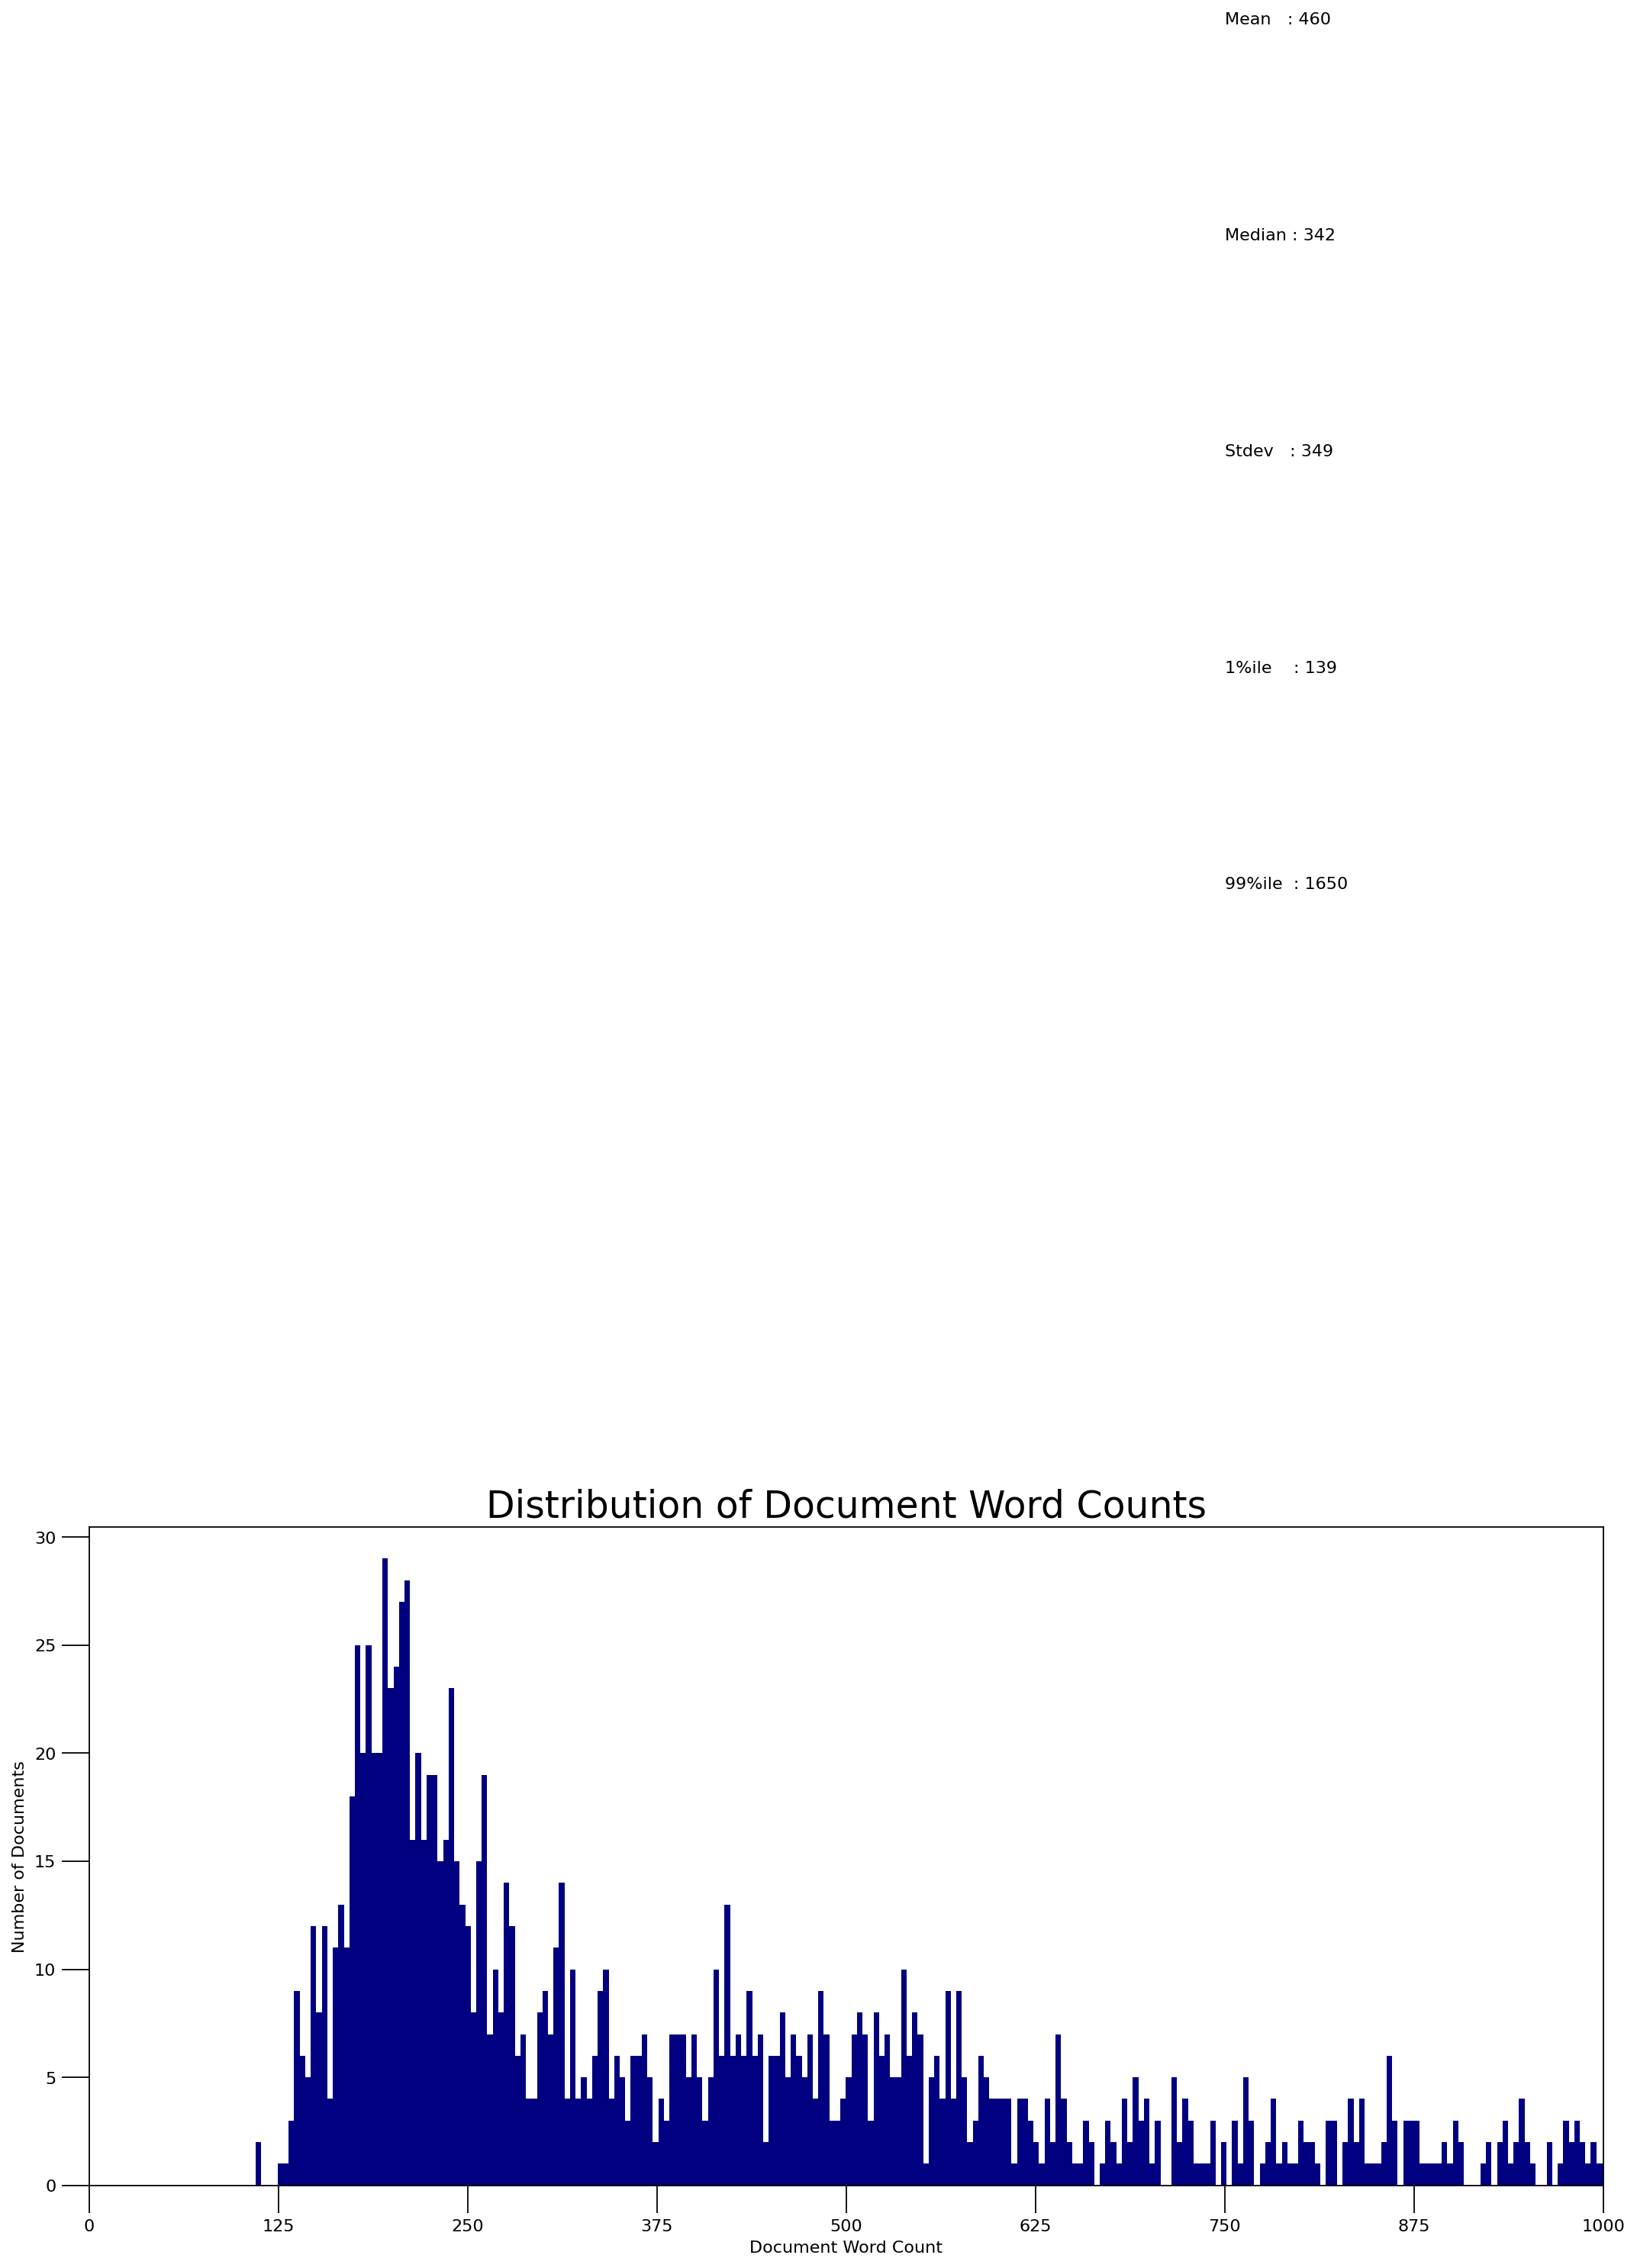

In [49]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

<ipython-input-50-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-50-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-50-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-50-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

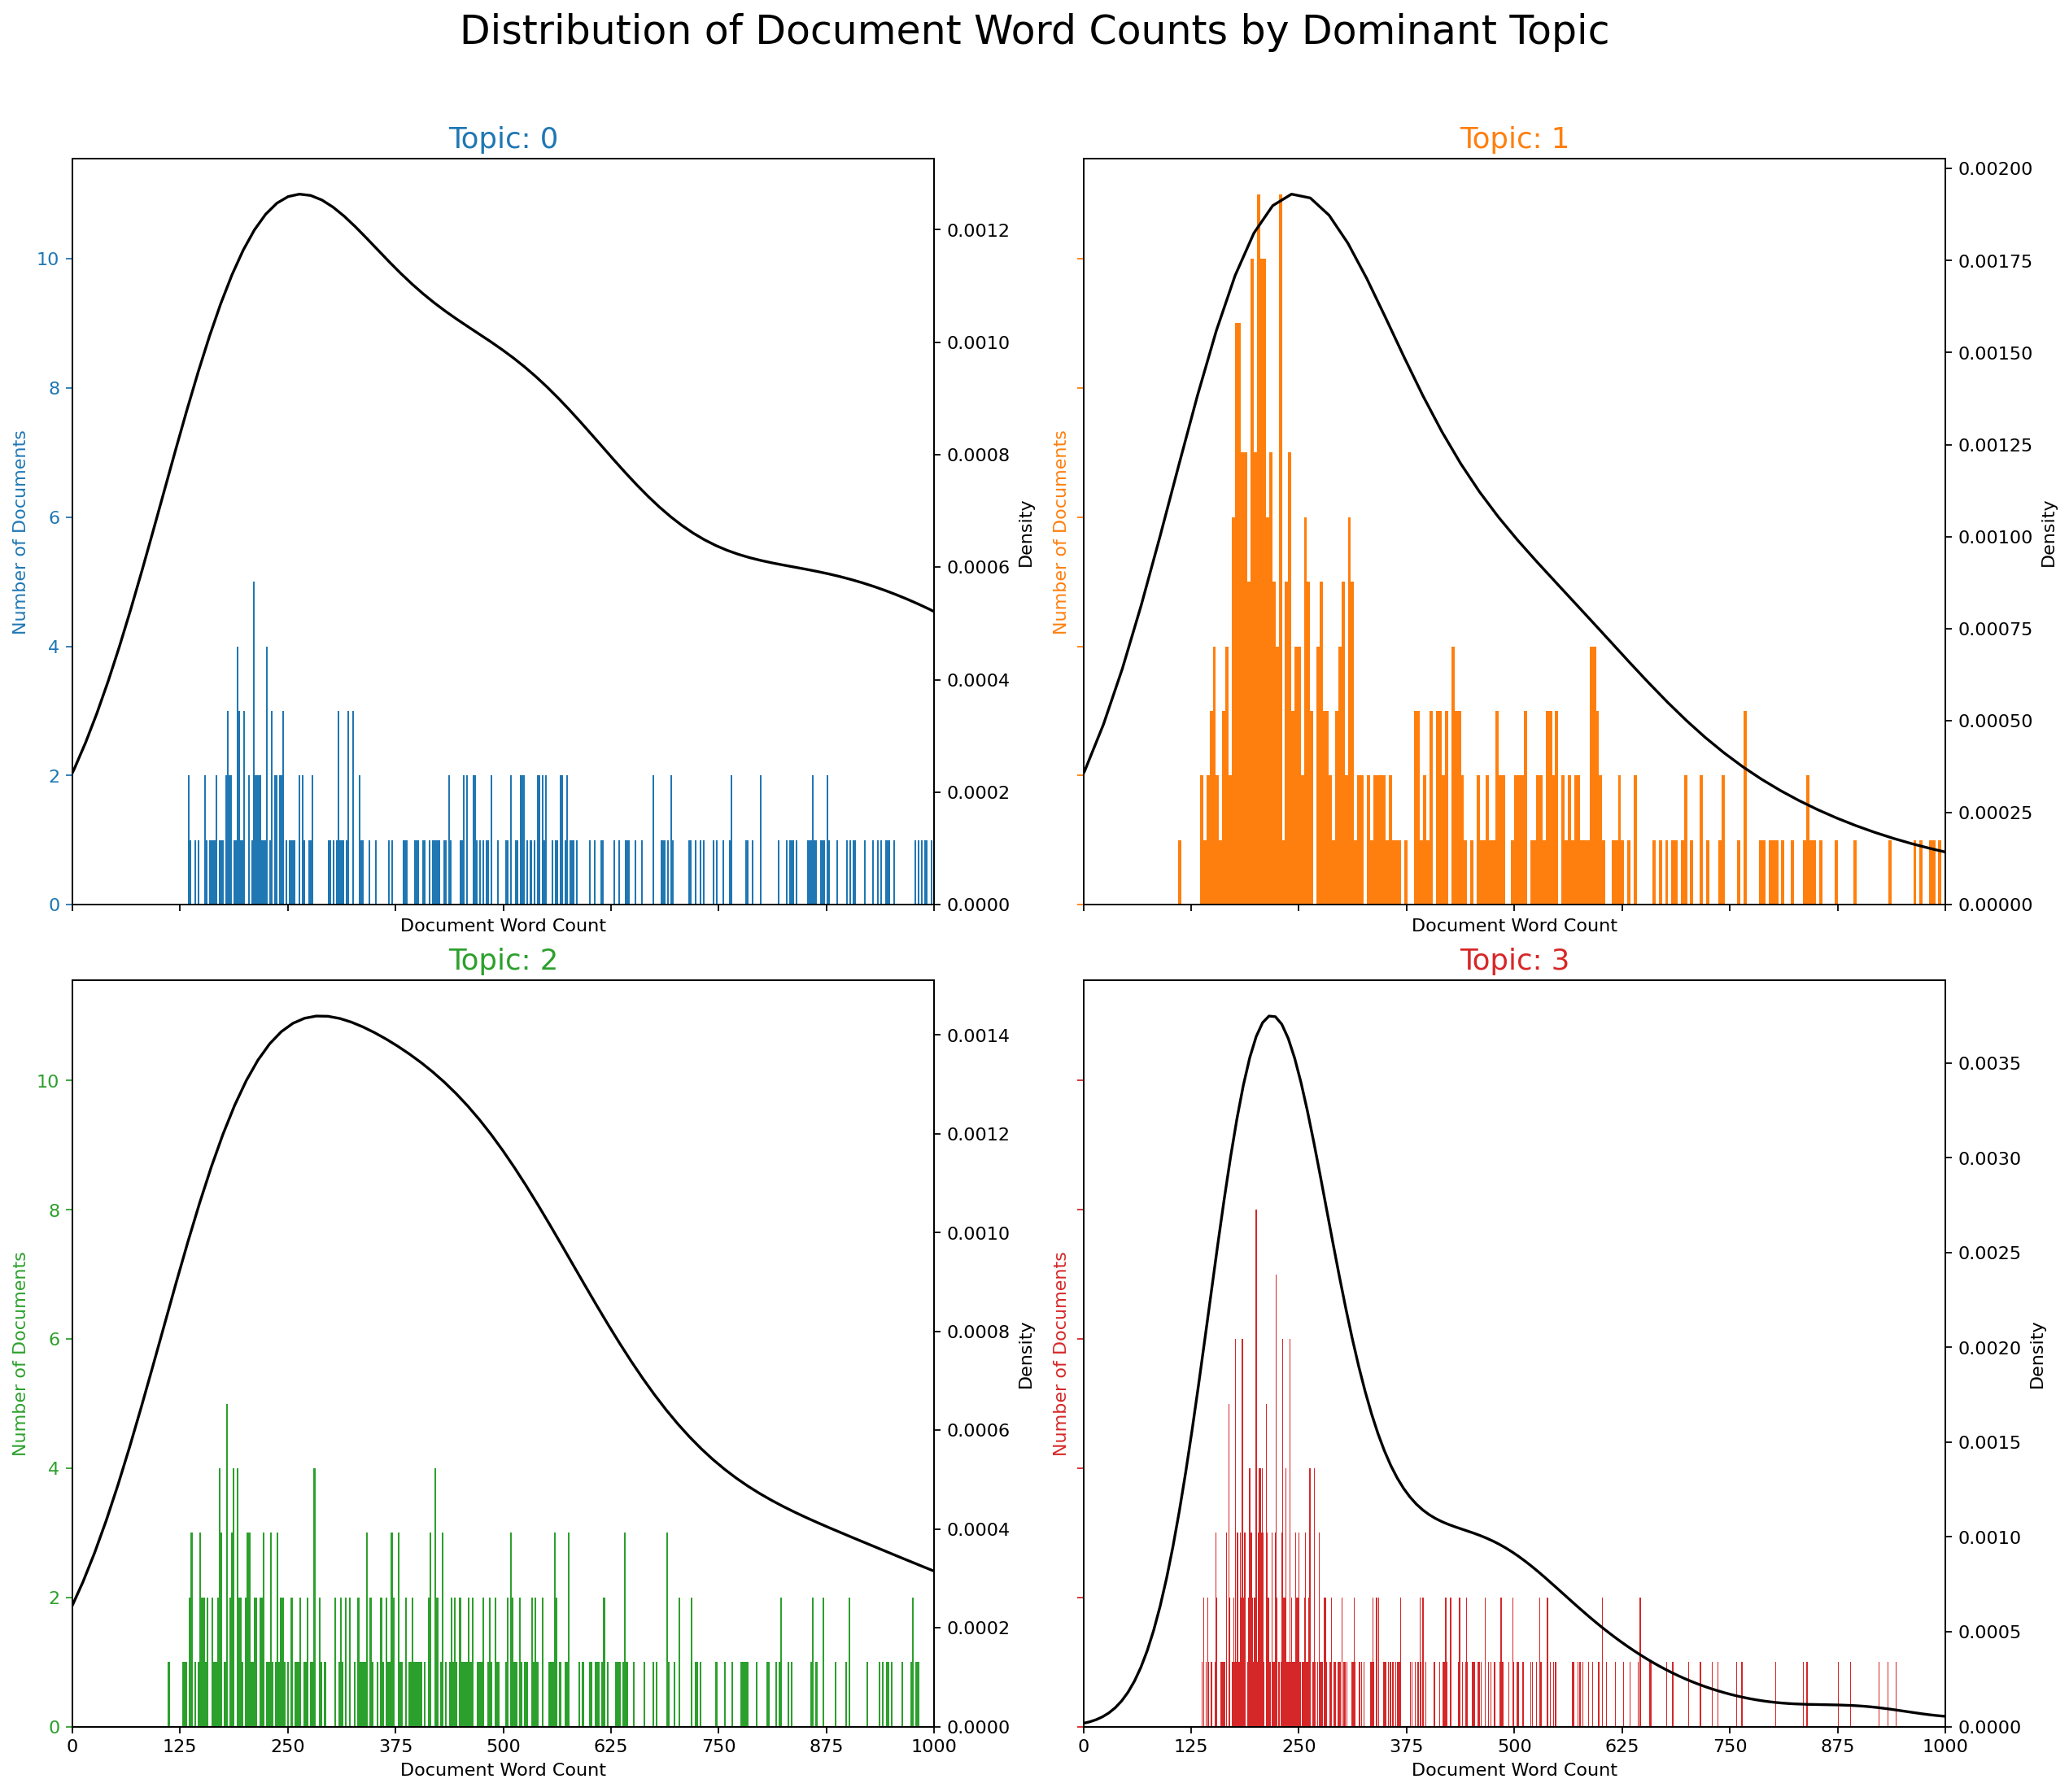

In [50]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

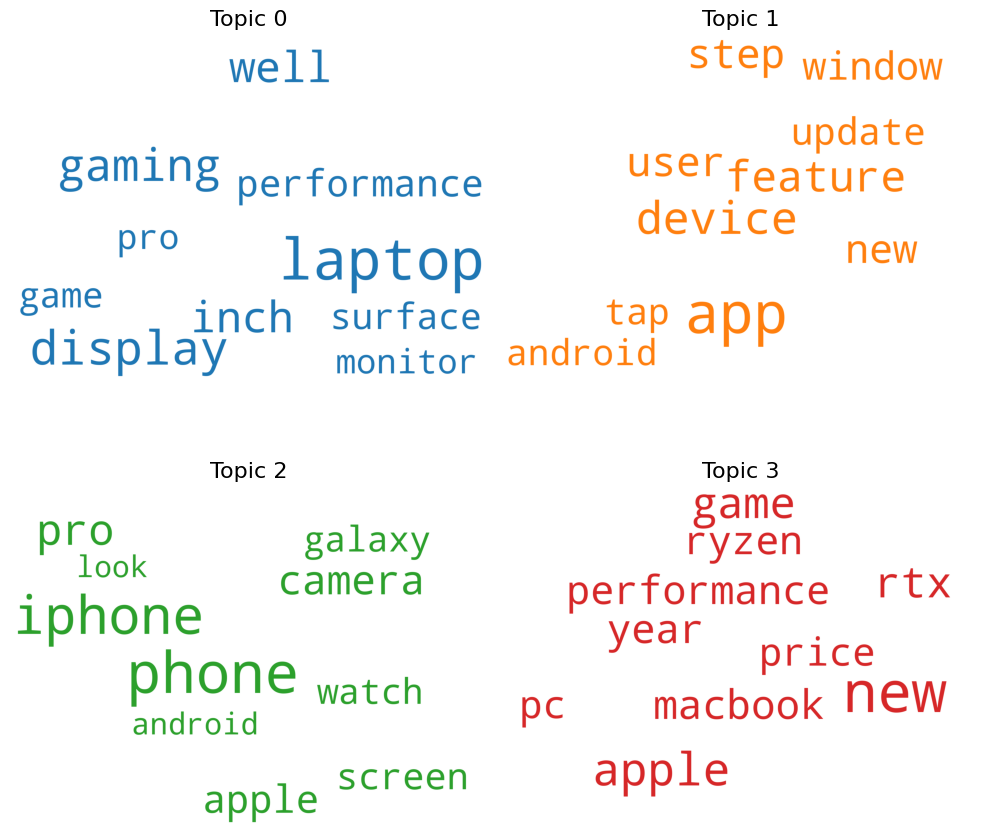

In [51]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-60-43df6a039458>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


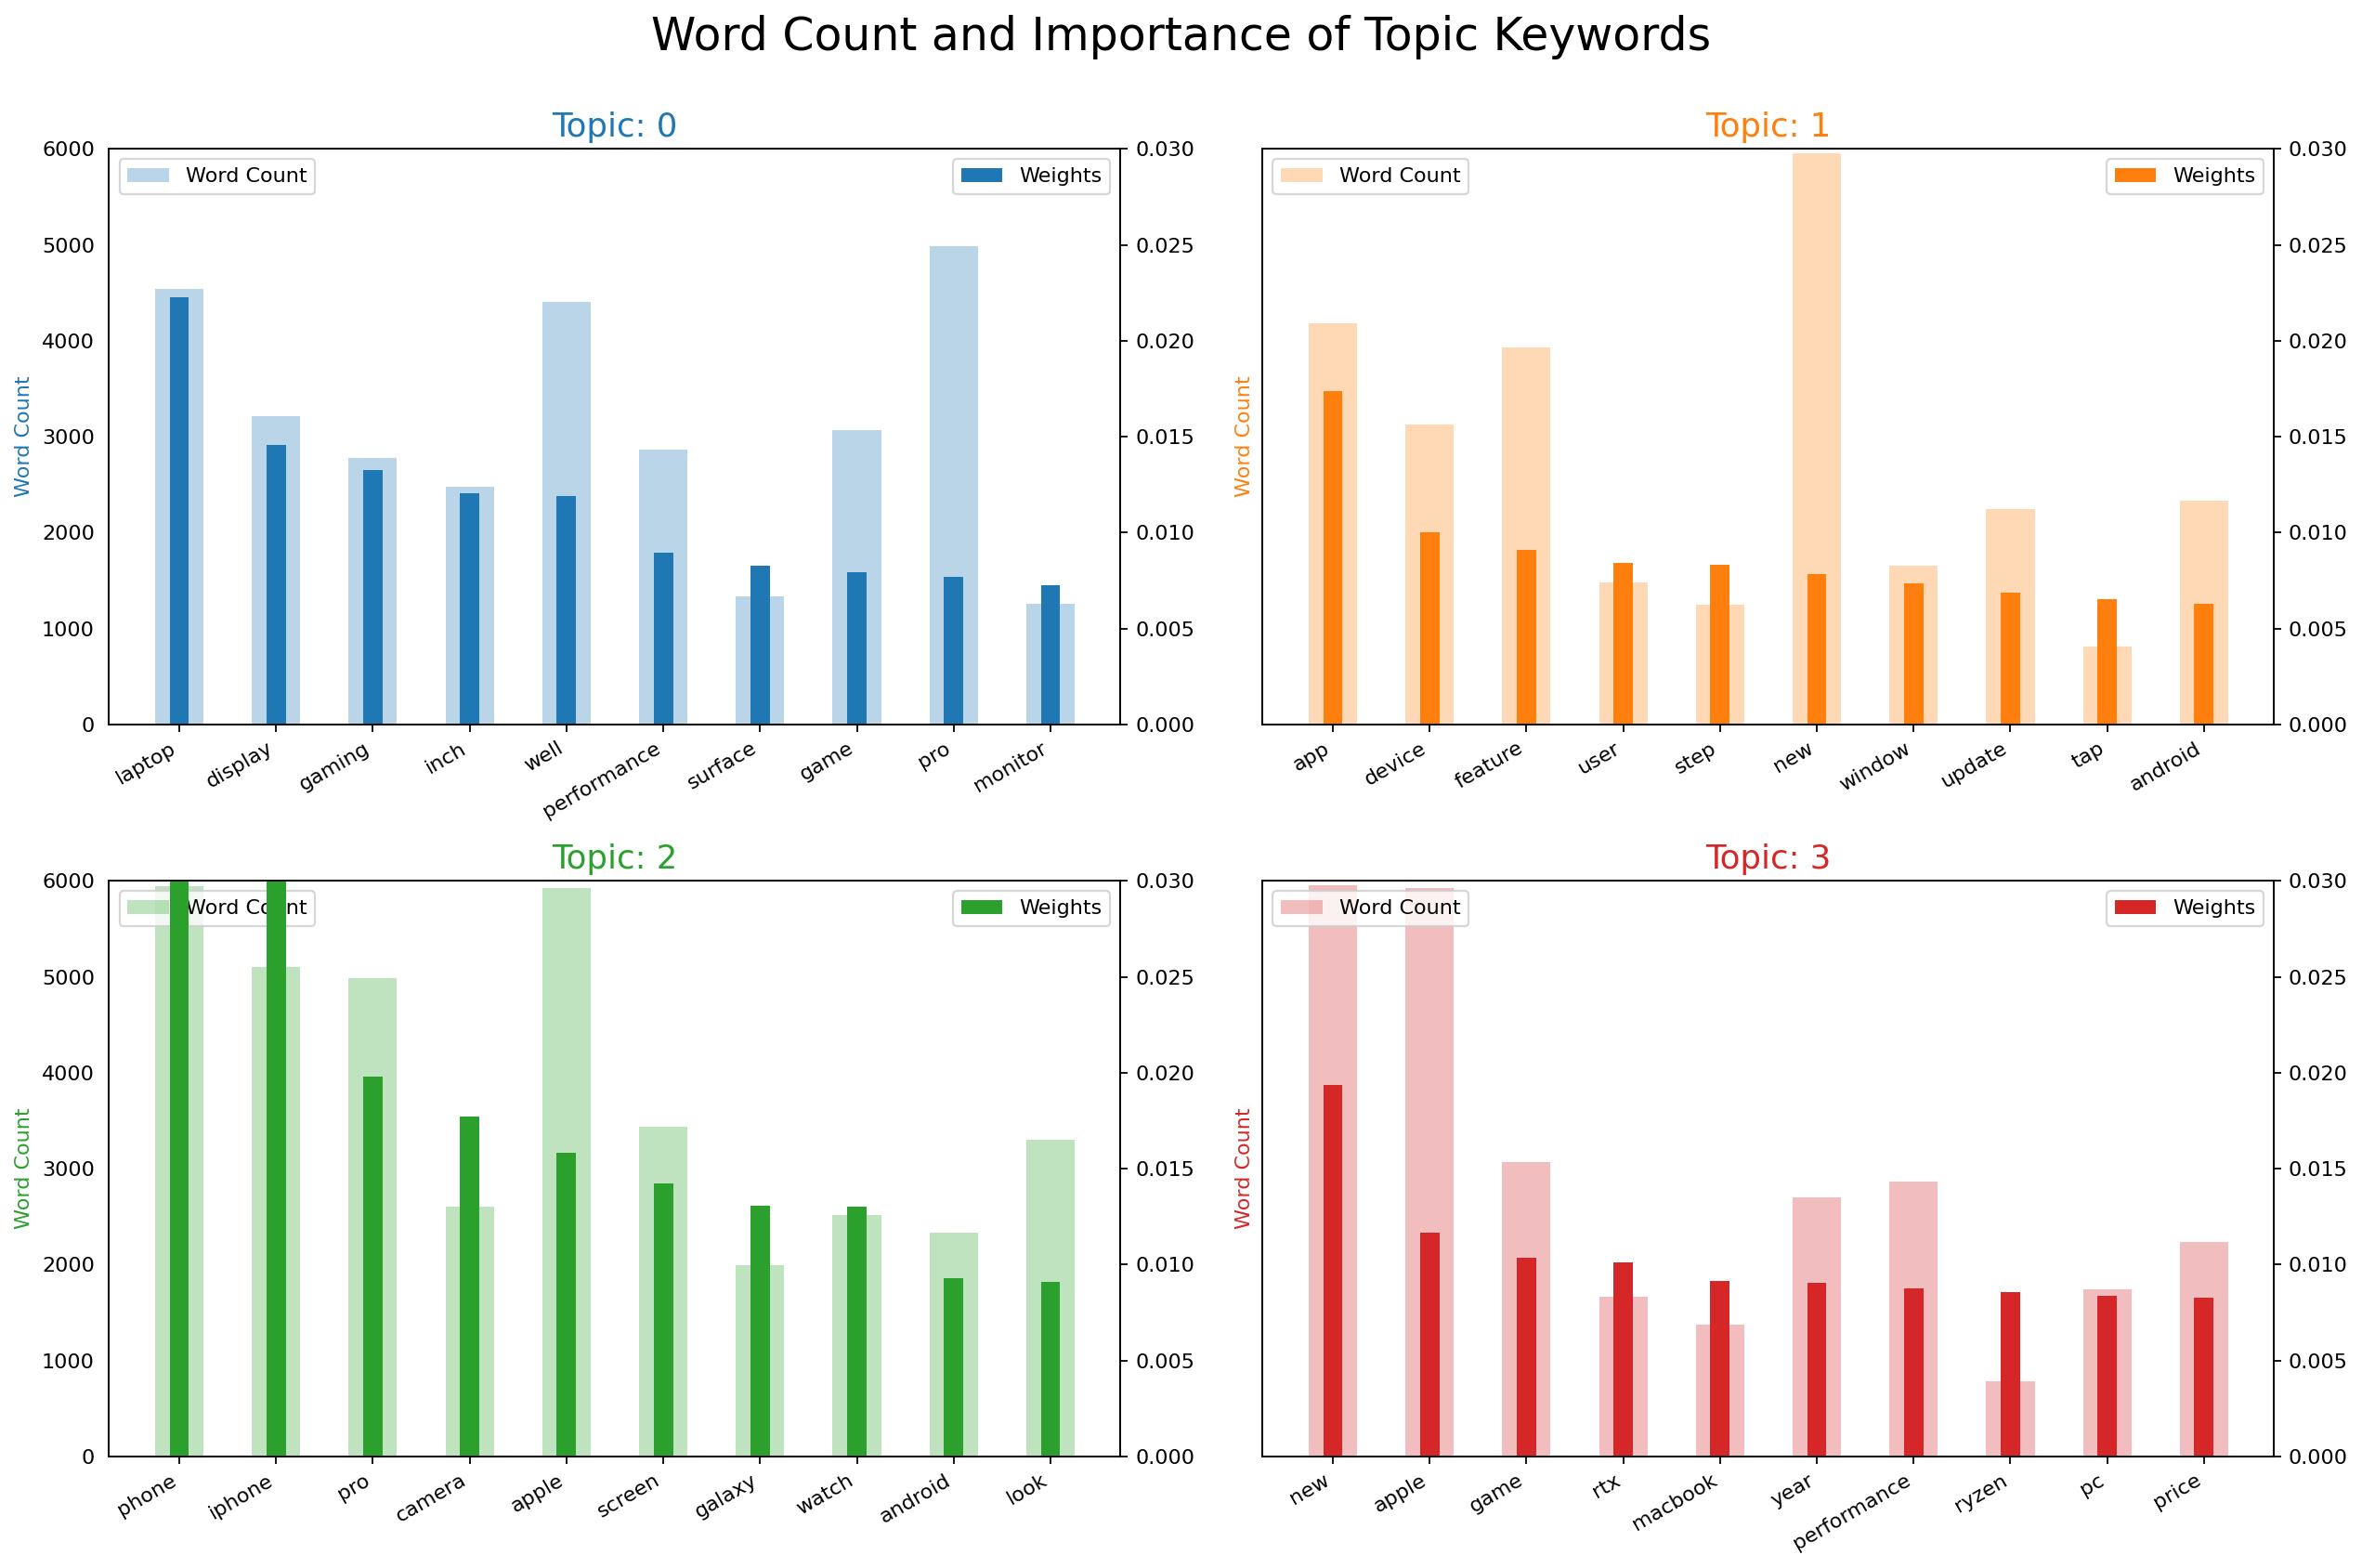

In [60]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

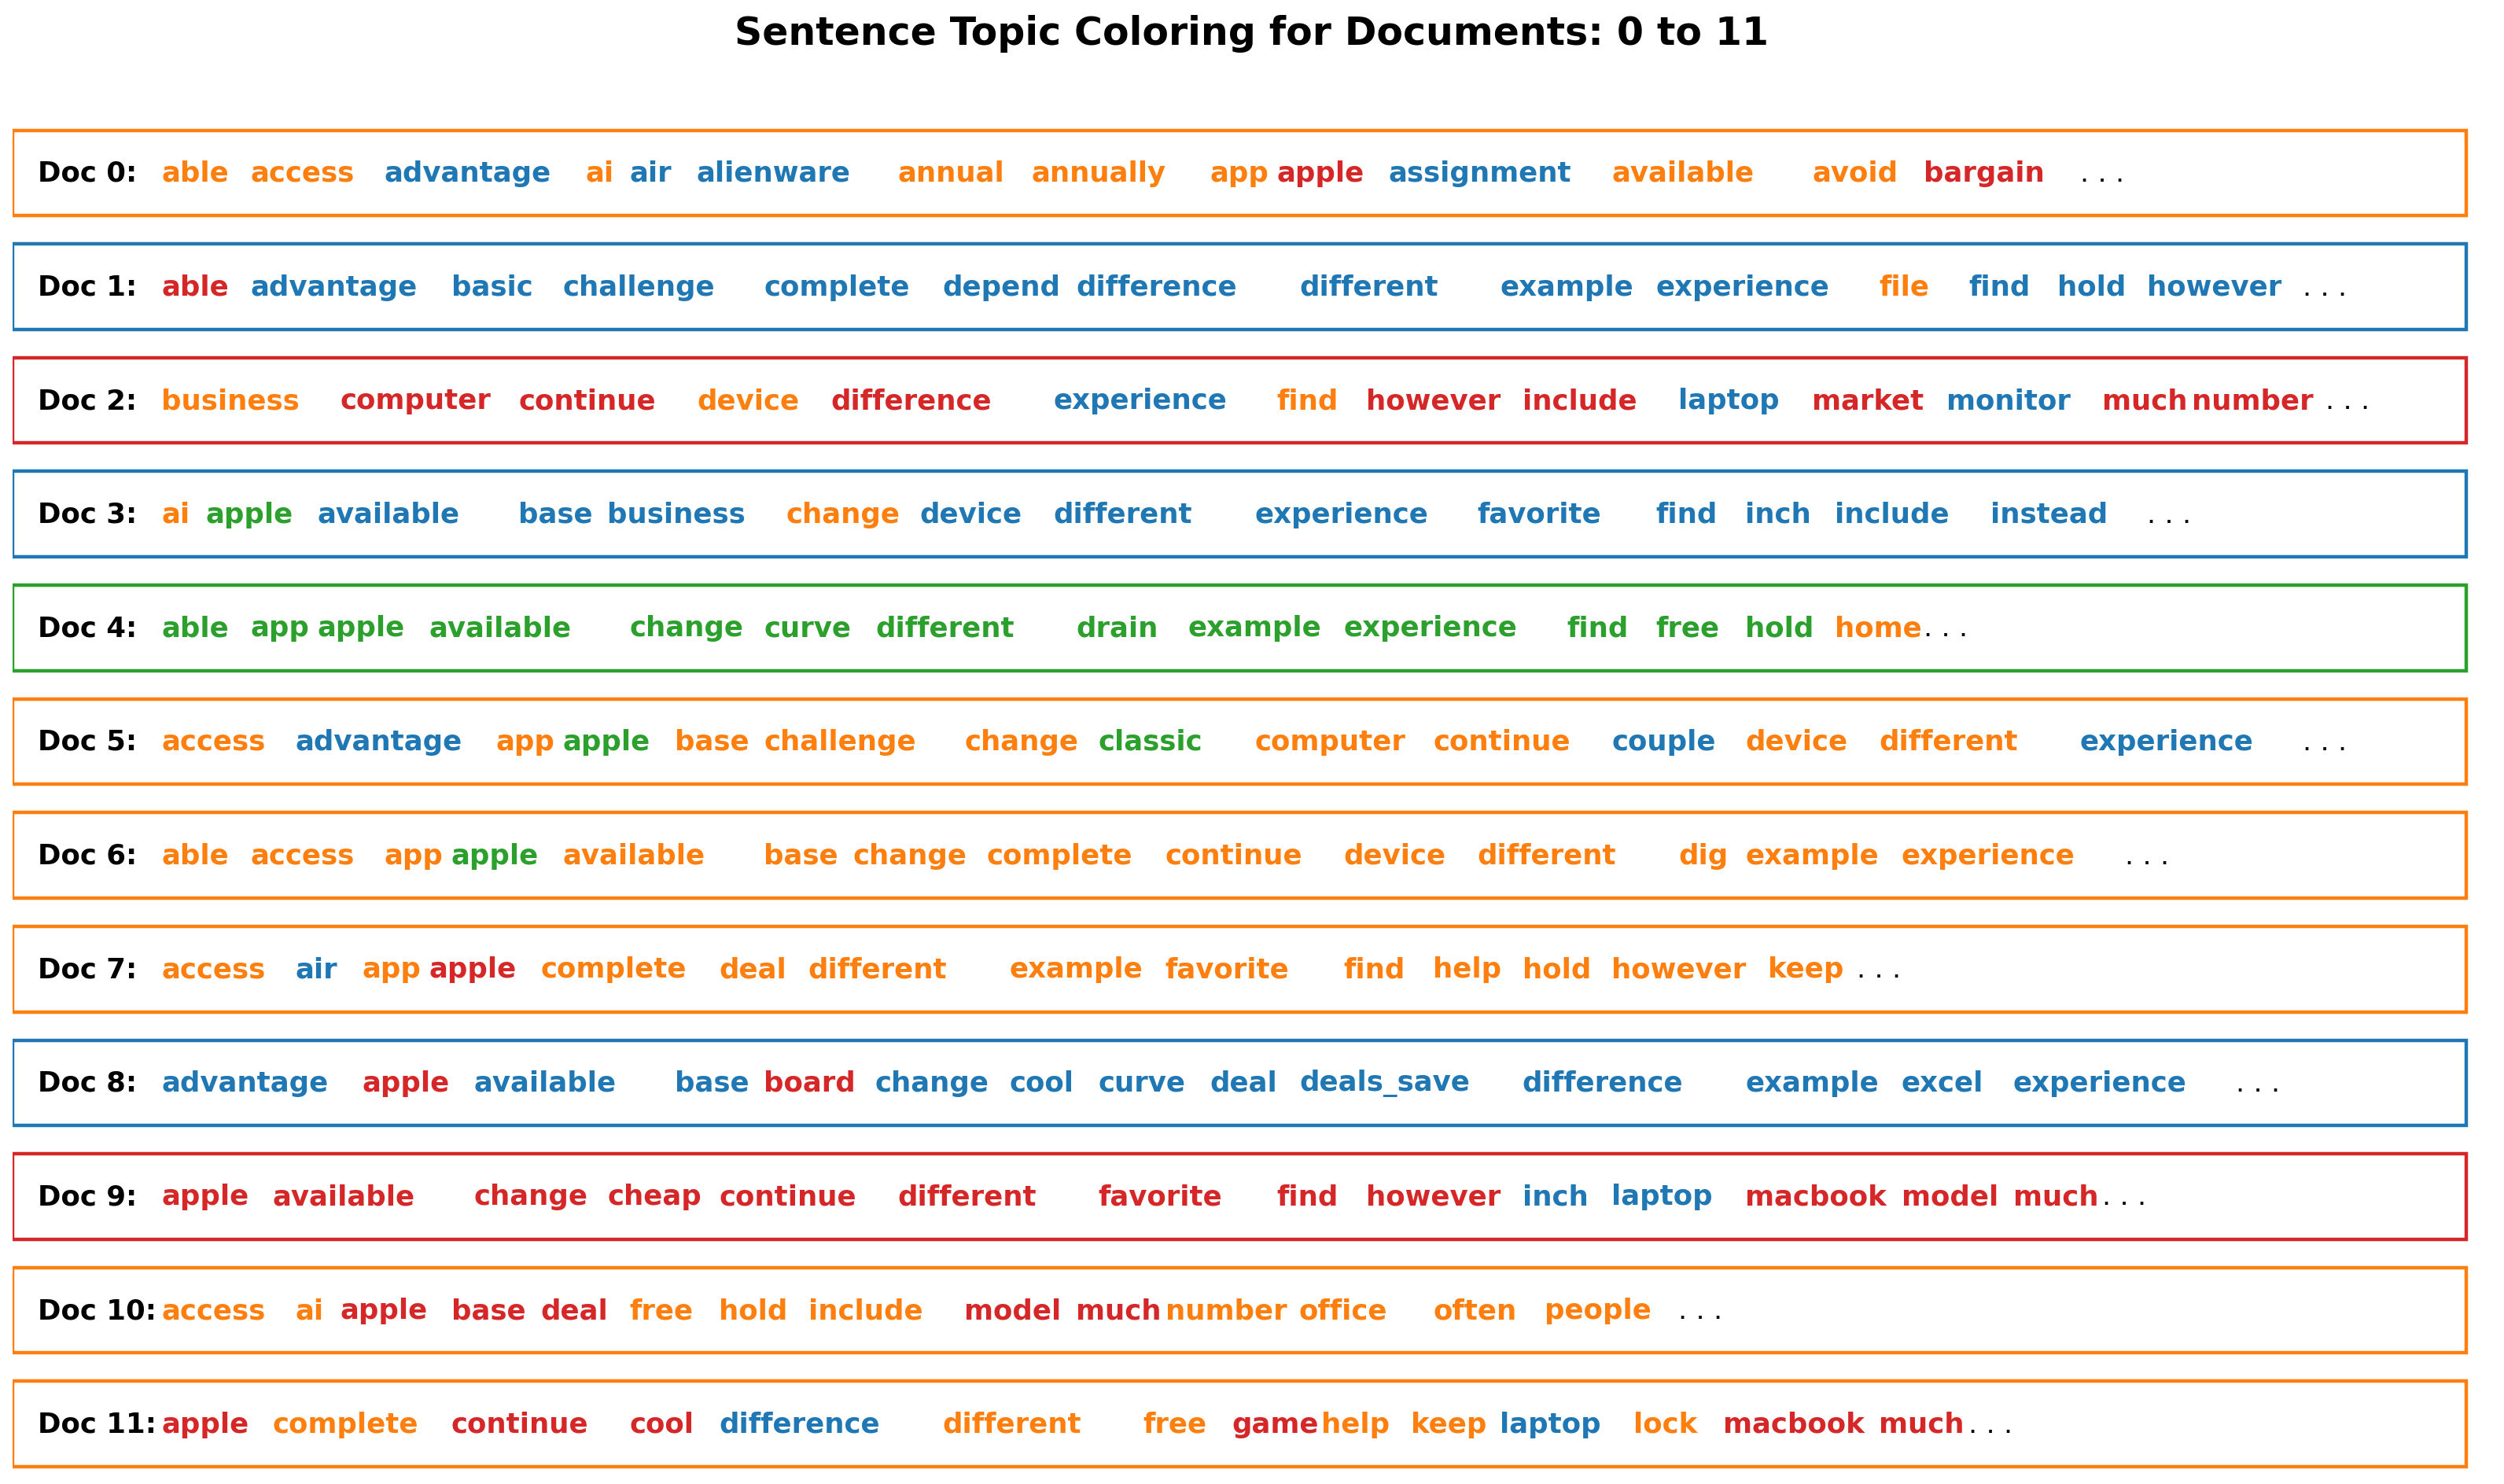

In [53]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [54]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

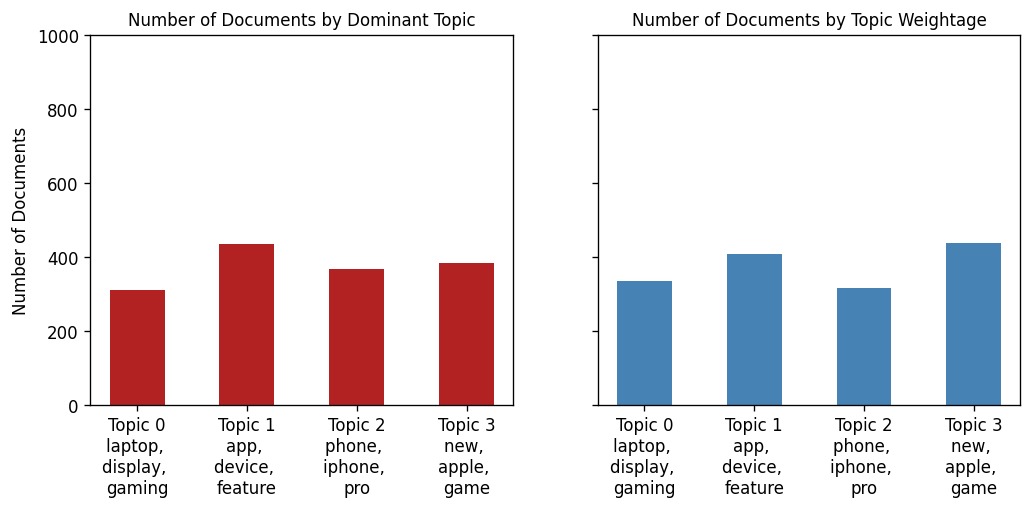

In [55]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!zip -r /content/digitalTrends.zip /content/digitalTrends
!zip -r /content/digitalTrendsEntities.zip /content/digitalTrendsEntities
!zip -r /content/whooshIndex.zip /content/whooshIndex
!zip -r /content/whooshIndexEntities.zip /content/whooshIndexEntities

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


updating: content/digitalTrends/ (stored 0%)
updating: content/digitalTrends/c8fc8accf93666aceb71465a3834c2fb.json (deflated 57%)
updating: content/digitalTrends/1288728495f83c6383cf92586d2d9a48.json (deflated 59%)
updating: content/digitalTrends/607f4dbb4486ff415904d53a02abac3a.json (deflated 57%)
updating: content/digitalTrends/29460a404bcc2e580b6b9f6333dbefb1.json (deflated 60%)
updating: content/digitalTrends/8e96d41927fd0465c313eb9add9293eb.json (deflated 54%)
updating: content/digitalTrends/faafea6f177d61fa6ecfe8281ae07c9f.json (deflated 63%)
updating: content/digitalTrends/c9804d3b52d60d5ce5a92d3844ace35c.json (deflated 58%)
updating: content/digitalTrends/c6e7e6a1f63e98f23482a3771960a975.json (deflated 56%)
updating: content/digitalTrends/cff85089406b8bcf3eb5c6e91e22f5df.json (deflated 73%)
updating: content/digitalTrends/56f7b0f1d96fb4449caedb83a19949e0.json (deflated 59%)
updating: content/digitalTrends/56833d25633cd323363e45e3b7aa1d2f.json (deflated 58%)
updating: content/di

mv: cannot move '/content/digitalTrends.zip' to '/content/drive/My Drive/Practica1TGINE/': No such file or directory


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
